# Jupyter notebook for the curve fitting problem

> Table of contents:
> - Section 0: Import data and plot
> - Section 1: SIR fitting
> - Section 2: noseg model fitting
> - Section 3: advanced fitting

# Section 0: Import data

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as pp
import pylab
import scipy
import pandas as pd
from scipy.optimize import curve_fit
#from  models_functions import mf_seg, mf_noseg, sir, mf_seg_plot, mf_noseg_plot

%matplotlib inline

In [2]:
# Import data
hoax_data = pd.read_csv('../../data/hoaxy_mexico-border-trump-elected_cum_day.csv',parse_dates=True)
for_users = hoax_data['For']
against_users = hoax_data['Against']
t_empirical=np.arange(0,len(hoax_data))
len_data= len(hoax_data)

# difference data
new_for_users = for_users.diff()[1:for_users.size]
new_against_users = against_users.diff()[1:for_users.size]
new_t_empirical = t_empirical[1:for_users.size]

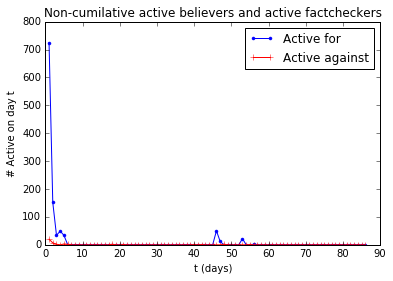

In [3]:
pp.figure()
pp.plot(new_t_empirical, new_for_users, 'b.-',new_t_empirical, new_against_users,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Non-cumilative active believers and active factcheckers")
pp.legend(['Active for', 'Active against'])
pp.show()

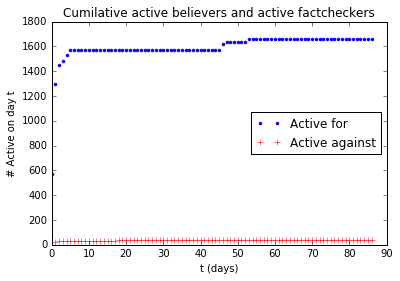

In [4]:
pp.figure()
pp.plot(t_empirical, for_users, 'b.',t_empirical, against_users,'r+')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers and active factcheckers")
pp.legend(['Active for', 'Active against'],loc=5)
pp.show()

# SECTION 1: Fit with SIR to make sure everything is working

SIR functions:

In [5]:
def f_SIR(Y, t, beta, mu):

    S = Y[0]
    I = Y[1]
    R = Y[2]

    N = S + I + R

    dS = - beta * I * S / N
    dI = beta * I * S / N - mu * I
    dR = mu * I

    dY = [ dS, dI, dR ]

    return dY

def sir_cum(T, X0, beta, mu, ONEoverN):

    # Initial conditions
    S0 = (1.0-X0)/ONEoverN
    I0 = X0/ONEoverN
    R0 = 0.0

    I = scipy.integrate.odeint(f_SIR,[S0, I0, R0], T, args = (beta, mu))[:,1]

    return (np.cumsum(np.asarray(I)))

First, clean the data a bit - take only the first 30 days

In [6]:
# Firstly, clean the data a bit - take only the n+1 days
n=30
t_empirical_month1 = new_t_empirical[0:n]
for_users_month1 = for_users[0:n]
against_users_month1 = against_users[0:n]
new_for_users_month1 = new_for_users[0:n]
new_against_users_month1 = new_against_users[0:n]

Next, we show (by playing around with some parameters) that the SIR can be a decent fit. First plot is non-cumulative data, second is cumulative

In [183]:
# Play around to see if SIR can possible fit

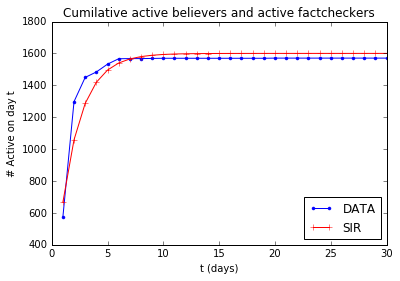

In [21]:
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        sir_cum(t_empirical_month1,0.5,0.25,0.65,0.00075),'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers and active factcheckers")
pp.legend(['DATA', 'SIR'],loc=4)
pp.show()

Now, try fitting the SIR model to the cumulative data

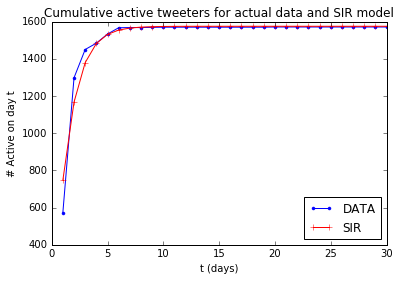

In [8]:
# Initial parameter estimates and bounds for parameters
param0 =[0.5,0.5,0.5,0.5]
param_bounds =([0, 0, 0, 0], [1., 1., 1., 1.])

# Curve fit
popt, cov = curve_fit(sir_cum, t_empirical_month1,for_users_month1,p0=param0,bounds=param_bounds)

# Output
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        sir_cum(t_empirical_month1,*popt),'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumulative active tweeters for actual data and SIR model")
pp.legend(['DATA', 'SIR'],loc=4)
pp.show()
pp.savefig('hoaxy_mexico_SIRfit.pdf', format='pdf')


# SECTION 2: The misinformation model

In [328]:
# Firstly, clean the data a bit - take only the n+1 days
n=15
t_empirical_month1 = new_t_empirical[0:n]
for_users_month1 = for_users[0:n]
against_users_month1 = against_users[0:n]
new_for_users_month1 = new_for_users[0:n]
new_against_users_month1 = new_against_users[0:n]

Define the function

In [304]:
def mf_noseg(T, alpha, ONEoverN, ba_init, pv, omega):

    # Network size
    N=1./ONEoverN

    # Initial conditions
    pBI0, pBA0, pFI0, pFA0, pS0 = 0.0, N*ba_init, 0.0, 0.0, N*(1.- ba_init)
    
    ba = []
    fa = []
    for i in T:

        ba.append(pBA0)
        fa.append(pFA0)
        
        f = pBA0/N
        pBI1 = alpha * f * pS0 + omega * pBA0 + (1. - pv) * (1. - f) * pBI0
        pBA1 = (1. - pv) * f  * pBI0 + (1. - omega) * (1. - pv) * pBA0
        pFI1 = (1-alpha) * f * pS0 + omega * pFA0 + pv * (pBI0 + (1. - omega) * pBA0) + (1 - f) * pFI0
        pFA1 = f * pFI0 + (1. - omega) * pFA0
        pS1 = (1. - f) * pS0

        #update
        pBI0, pBA0, pFI0, pFA0, pS0 = pBI1, pBA1, pFI1, pFA1, pS1

        if float(pBI0)<=0.0000000001:
            pBI0=0.0
        if float(pBA0)<=0.0000000001:
            pBA0=0.0
        if float(pFI0)<=0.0000000001:
            pFI0=0.0
        if float(pFA0)<=0.0000000001:
            pFA0=0.0
        if float(pS0)<=0.0000000001:
            pS0=0.0

    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))

def mf_noseg_BA(T, alpha, ONEoverN, ba_init, pv, omega):
    return mf_noseg(T, alpha, ONEoverN, ba_init, pv, omega)[0]

def mf_noseg_FA(T, alpha, ONEoverN, ba_init, pv, omega):
    return mf_noseg(T, alpha, ONEoverN, ba_init, pv, omega)[1]

def fit_MF(T_double, alpha, ONEoverN, ba_init, pv, omega):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_noseg(T, alpha, ONEoverN, ba_init, pv, omega)
    return np.append(BA, FA)
    

### Firstly, fit parameters to the FOR curve and use these paramters to predict the AGAINST curve

In [305]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, pv, omega]
param0 =0.5,0.0001,0.5,0.5,0.5
param_bounds =([0., 0., 0, 0., 0.], [1., 1., 1., 1., 1.])

# Curve fit
poptFOR, covFOR = curve_fit(mf_noseg_BA, t_empirical_month1, for_users_month1, p0=param0,bounds=param_bounds)

[  1.46619140e-13   4.09522809e-04   3.16893344e-01   4.88880438e-01
   6.21818045e-11]


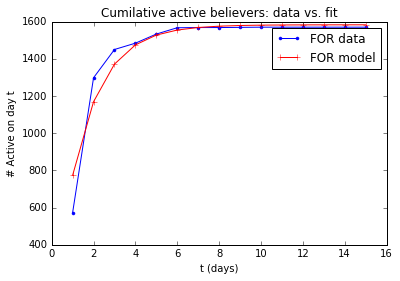

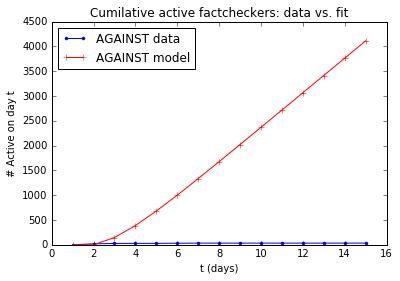

In [312]:
print poptFOR
BA, FA = mf_noseg(t_empirical_month1,*poptFOR)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitFOR_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitFOR_against.pdf')
pp.show()

### Alternative: fit parameters to the AGAINST curve and use these paramters to predict the FOR curve

In [313]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, pv, omega]
param0 =0.5,0.0001,0.5,0.5,0.5
param_bounds =([0., 0., 0, 0., 0.], [1., 1., 1., 1., 1.])

# Curve fit
poptAGAINST, covAGAINST = curve_fit(mf_noseg_FA, t_empirical_month1, against_users_month1, 
                                    p0=param0,bounds=param_bounds, max_nfev=1000)

[  5.55302665e-09   2.64071736e-07   3.25219272e-01   9.99726319e-01
   7.51997410e-01]


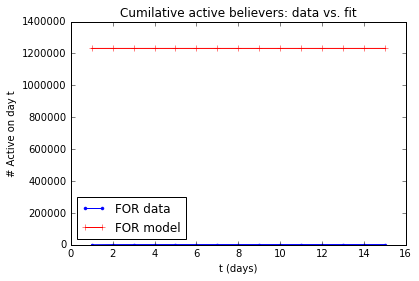

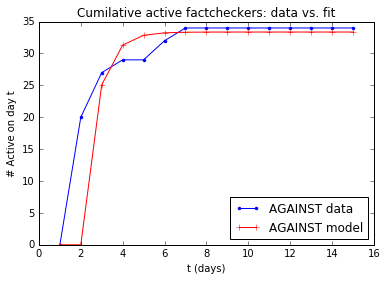

In [315]:
print poptAGAINST
BA, FA = mf_noseg(t_empirical_month1,*poptAGAINST)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitAGAINST_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitAGAINST_against.pdf')
pp.show()

In [282]:
?scipy.optimize.least_squares

### Fit parameters to FOR curve and AGAINST curve

In [317]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, pv, omega]
#param0 = 0.5,0.0001,0.5,0.5,0.5
a=0.5
param0 = a*poptAGAINST + (1.-a)*poptFOR
param_bounds =([0., 0., 0, 0., 0.], [1., 1., 1., 1., 1.])

# Curve fit
T_double = np.append(t_empirical_month1, t_empirical_month1)
data_double = np.append(for_users_month1, against_users_month1)
poptBOTH, cov = curve_fit(fit_MF, T_double, data_double, p0=param0,bounds=param_bounds)

[  7.64147309e-09   1.16155316e-05   9.00032431e-03   2.67233703e-01
   3.04876778e-01]


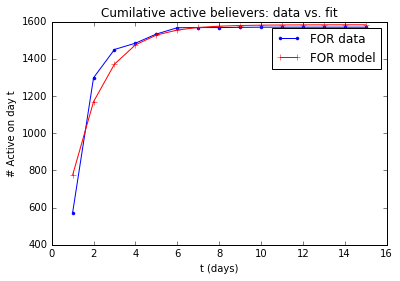

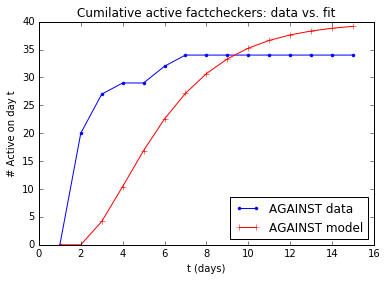

In [318]:
print poptBOTH
BA, FA = mf_noseg(t_empirical_month1,*poptBOTH)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitFORAGAINST_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitFORAGAINST_against.pdf')
pp.show()

# SECTION 3: Modify model to include initial inactive believers and inactive factcheckers

In [319]:
def mf_noseg2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega):

    # Network size
    N=1./ONEoverN

    # Initial conditions
    pBI0, pBA0, pFI0, pFA0, pS0 = N*bi_init, N*ba_init, N*fi_init, 0.0, N*(1.- (ba_init+bi_init+fi_init))
    
    ba = []
    fa = []
    for i in T:

        ba.append(pBA0)
        fa.append(pFA0)
        
        f = pBA0/N
        pBI1 = alpha * f * pS0 + omega * pBA0 + (1. - pv) * (1. - f) * pBI0
        pBA1 = (1. - pv) * f  * pBI0 + (1. - omega) * (1. - pv) * pBA0
        pFI1 = (1-alpha) * f * pS0 + omega * pFA0 + pv * (pBI0 + (1. - omega) * pBA0) + (1 - f) * pFI0
        pFA1 = f * pFI0 + (1. - omega) * pFA0
        pS1 = (1. - f) * pS0

        #update
        pBI0, pBA0, pFI0, pFA0, pS0 = pBI1, pBA1, pFI1, pFA1, pS1

        if float(pBI0)<=0.0000000001:
            pBI0=0.0
        if float(pBA0)<=0.0000000001:
            pBA0=0.0
        if float(pFI0)<=0.0000000001:
            pFI0=0.0
        if float(pFA0)<=0.0000000001:
            pFA0=0.0
        if float(pS0)<=0.0000000001:
            pS0=0.0

    return np.cumsum(np.asarray(ba)), np.cumsum(np.asarray(fa))

def mf_noseg_BA2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega):
    return mf_noseg2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega)[0]

def mf_noseg_FA2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega):
    return mf_noseg2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega)[1]

def fit_MF2(T_double, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega):
    T = T_double[:len(T_double)/2]
    BA, FA = mf_noseg2(T, alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega)
    return np.append(BA, FA)
    

### Again, train model only on FOR data

In [320]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega]
param0 =0.5,0.0001,0.1,0.1,0.1,0.5,0.5
param_bounds =([0., 0., 0, 0., 0., 0., 0.], [1., 1., 1., 1., 1., 1., 1.])

# Curve fit
poptFOR2, covFOR2 = curve_fit(mf_noseg_BA2, t_empirical_month1, for_users_month1, p0=param0,bounds=param_bounds)

[  9.99999897e-01   5.77812652e-04   3.86317630e-01   9.99987788e-01
   1.00000000e+00   4.14657919e-01   4.81904632e-01]


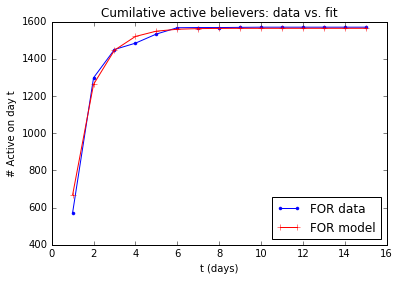

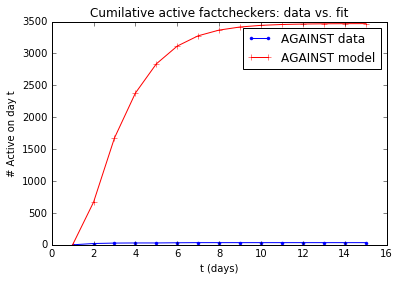

In [321]:
print poptFOR2
BA, FA = mf_noseg2(t_empirical_month1,*poptFOR2)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitFOR2_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.show()

### Alternative, train on AGAINST data

In [276]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, bi_init, fi_init, pv, omega]
param0 =0.5,0.0001,0.1,0.1,0.1,0.5,0.5
param_bounds =([0., 0., 0, 0., 0., 0., 0.], [1., 1., 1., 1., 1., 1., 1.])

# Curve fit
poptAGAINST2, covAGAINST2 = curve_fit(mf_noseg_FA2, t_empirical_month1, against_users_month1, p0=param0,bounds=param_bounds)

[  1.00000000e+00   7.03277452e-04   8.95049315e-02   5.90700574e-05
   1.43252657e-01   1.00000000e+00   5.42167069e-01]


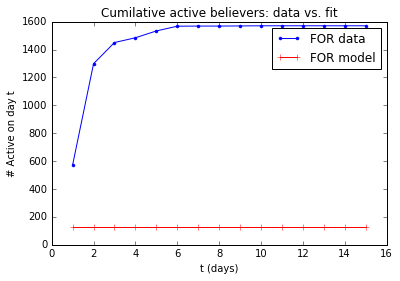

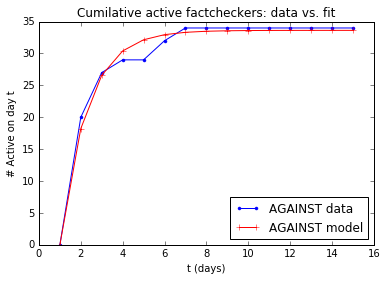

In [322]:
print poptAGAINST2
BA, FA = mf_noseg2(t_empirical_month1,*poptAGAINST2)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitAGAINST2_against.pdf')
pp.show()

### Combo

In [292]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, pv, omega]
#param0 =0.5,0.0001,0.1,0.1,0.1,0.5,0.5
a=0.9
param0 = a*poptAGAINST2 + (1.-a)*poptFOR2
param_bounds =([0., 0., 0, 0., 0., 0., 0.], [1., 1., 1., 1., 1., 1., 1.])

# Curve fit
T_double = np.append(t_empirical_month1, t_empirical_month1)
data_double = np.append(for_users_month1, against_users_month1)
poptBOTH2, cov = curve_fit(fit_MF2, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=100000)

[  9.67476924e-02   1.99764111e-07   1.51484770e-04   5.68568695e-01
   4.24115036e-44   4.51427193e-02   1.00000000e+00]


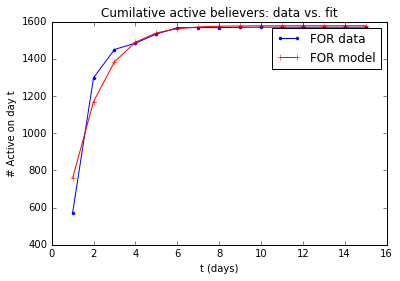

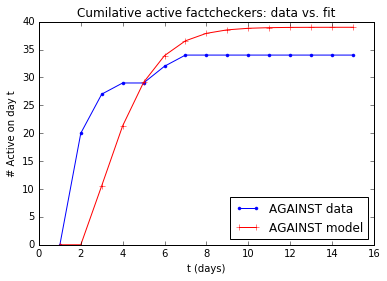

In [329]:
print poptBOTH2
BA, FA = mf_noseg2(t_empirical_month1,*poptBOTH2)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitFORAGAINST2_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitFORAGAINST2_against.pdf')
pp.show()

### Other option, longer time period to weigh the effects of wrong steady states

In [324]:
# Firstly, clean the data a bit - take only the n+1 days
n=50
t_empirical_month1 = new_t_empirical[0:n]
for_users_month1 = for_users[0:n]
against_users_month1 = against_users[0:n]
new_for_users_month1 = new_for_users[0:n]
new_against_users_month1 = new_against_users[0:n]

In [325]:
# Initial parameter estimates and bounds for parameters
# param0 = [alpha, ONEoverN, ba_init, pv, omega]
#param0 =0.5,0.0001,0.1,0.1,0.1,0.5,0.5
a=0.9
param0 = a*poptAGAINST2 + (1.-a)*poptFOR2
param_bounds =([0., 0., 0, 0., 0., 0., 0.], [1., 1., 1., 1., 1., 1., 1.])

# Curve fit
T_double = np.append(t_empirical_month1, t_empirical_month1)
data_double = np.append(for_users_month1, against_users_month1)
poptBOTH2, cov = curve_fit(fit_MF2, T_double, data_double, p0=param0,bounds=param_bounds, max_nfev=100000)

[  9.67476924e-02   1.99764111e-07   1.51484770e-04   5.68568695e-01
   4.24115036e-44   4.51427193e-02   1.00000000e+00]


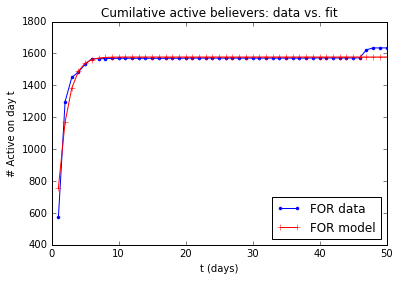

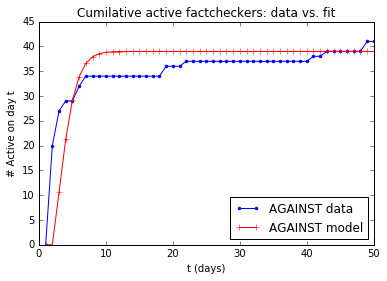

In [326]:
print poptBOTH2
BA, FA = mf_noseg2(t_empirical_month1,*poptBOTH2)
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        BA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers: data vs. fit")
pp.legend(['FOR data', 'FOR model'],loc=0)
pp.savefig('fitFORAGAINST3_for.pdf')
pp.show()
pp.figure()
pp.plot(t_empirical_month1, against_users_month1, 'b.-',t_empirical_month1, 
        FA,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active factcheckers: data vs. fit")
pp.legend(['AGAINST data', 'AGAINST model' ],loc=0)
pp.savefig('fitFORAGAINST3_against.pdf')
pp.show()

In [332]:
print poptBOTH
print poptBOTH2

[  7.64147309e-09   1.16155316e-05   9.00032431e-03   2.67233703e-01
   3.04876778e-01]
[  9.67476924e-02   1.99764111e-07   1.51484770e-04   5.68568695e-01
   4.24115036e-44   4.51427193e-02   1.00000000e+00]
